In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [184]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [185]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [186]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [187]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [188]:
data = data[data['FIPS'] != 'not county']

In [189]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [190]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [191]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [192]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str})

In [193]:
population.columns = ['FIPS', 'urban_influence', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [194]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [195]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [196]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [197]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,0.033898
5,01007,1.0,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [198]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [199]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,-0.033898
5,01007,1.0,22533,-0.016670,0.102094


In [200]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [201]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
data = data.join(unemployment.set_index('FIPS'))

In [202]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
data = data.join(poverty.set_index('FIPS'))

In [203]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [204]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [205]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [206]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [207]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [208]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [209]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [210]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [211]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [212]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [213]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [214]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [215]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [216]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [217]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [218]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [219]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [220]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [221]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [222]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [223]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [224]:
data.isnull().sum()

state               0
name                0
< diploma          10
degree+            10
urban_influence    10
pop_2014           10
pop_inc            10
foreign_inc        13
unemployment       11
poverty            13
median_hh_inc      13
median_age          9
hh_afr_am          11
hh_hisp            11
hh_female          11
hh_food_st         11
foreign_07          9
vets               11
vets_male           9
viol_crime         18
prop_crime         18
dtype: int64

In [225]:
len(data.dropna())

3130

In [226]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [227]:
data = data.dropna()

In [228]:
(data == 0).sum()

state                0
name                 0
< diploma            0
degree+              0
urban_influence      0
pop_2014             0
pop_inc              0
foreign_inc        156
unemployment         0
poverty              0
median_hh_inc        0
median_age           0
hh_afr_am           85
hh_hisp              4
hh_female            2
hh_food_st           3
foreign_07          33
vets                 0
vets_male            0
viol_crime         163
prop_crime         100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [229]:
data.describe()

,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,poverty,median_hh_inc,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,5.252716,1.017577e+05,0.002831,0.395946,6.235559,16.837380,47121.392971,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.492818,3.263767e+05,0.041968,3.043823,2.256287,6.422444,12099.573945,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,1.000000,8.900000e+01,-0.177510,-6.333333,1.200000,3.200000,21658.000000,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,2.000000,1.102950e+04,-0.021689,0.007641,4.600000,12.100000,38889.000000,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,5.000000,2.574250e+04,-0.004227,0.057769,6.000000,15.800000,45227.500000,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,8.000000,6.785250e+04,0.020261,0.200482,7.500000,20.400000,52529.750000,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,12.000000,1.007270e+07,0.727044,119.000000,24.000000,47.400000,125635.000000,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


In [230]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [231]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [232]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [233]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [234]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [235]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [236]:
data = data.join(targets.set_index('FIPS')) # drop na

In [237]:
data.isnull().sum()

state              0
name               0
< diploma          0
degree+            0
urban_influence    0
pop_2014           0
pop_inc            0
foreign_inc        0
unemployment       0
poverty            0
median_hh_inc      0
median_age         0
hh_afr_am          0
hh_hisp            0
hh_female          0
hh_food_st         0
foreign_07         0
vets               0
vets_male          0
viol_crime         0
prop_crime         0
death_rate         4
numeric            4
dtype: int64

In [238]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,poverty,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1.0,479488.0,0.085790,0.054824,5.7,12.9,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1.0,61706.0,0.104081,0.045556,4.2,4.0,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1.0,558519.0,0.044853,0.059893,4.6,8.3,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2.0,275584.0,0.090019,0.018015,4.5,10.5,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [239]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [240]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [241]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [242]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


The distribution is highly uneven and potentially problematic. Remove but keep in a secondary dataset.. 

In [243]:
data_31 = data.copy()
data = data[data['death_rate'] != '30+']

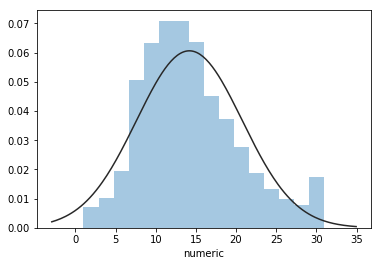

In [244]:
from scipy.stats import norm
sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
#targets['numeric'].hist(bins=16)

The target distribution is not normal, but it follows the general shape of a normal curve except for the high-end spike at death_rate = 31. The class imbalance will have to be dealt with.

In [245]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.590198  0.173795     0.014397      0.420872   
degree+         0.590198  1.000000  0.436721     0.037746      0.329834   
pop_inc         0.173795  0.436721  1.000000     0.001243      0.253635   
foreign_inc     0.014397  0.037746  0.001243     1.000000      0.003454   
unemployment    0.420872  0.329834  0.253635     0.003454      1.000000   
poverty         0.663283  0.447611  0.267106     0.014567      0.600237   
median_hh_inc   0.542180  0.680273  0.466601     0.018149      0.454140   
median_age      0.221839  0.178017  0.364938     0.035829      0.061179   
hh_afr_am       0.363750  0.091370  0.102100     0.003461      0.422107   
hh_hisp         0.452917  0.020773  0.177056     0.001030      0.013150   
hh_female       0.546617  0.243373  0.041391     0.005559      0.537112   
hh_food_st      0.634201  0.511206  0.236201     0.011188      0.577440   
foreign_07      0.235792 

**poverty** correlates strongly with a couple of other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [246]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

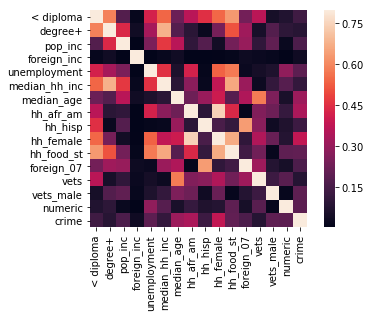

In [247]:
corrmat = data.drop(['state', 'name', 'urban_influence', 'pop_2014', 'death_rate'], axis=1).corr().abs()
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There are still some strong correlations, but they are scattered. Use VIF analysis to programmatically eliminate the variables with the highest VIF scores until all scores are below 10, a conservative threshold.

In [248]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each column in features, calculate VIF and save in dataframe
vif = pd.DataFrame()
remove = ['state', 'name', 'urban_influence', 'pop_2014', 'death_rate', 'numeric']
features = data.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,23.680630,< diploma
1,18.903080,degree+
2,1.634070,pop_inc
3,1.022008,foreign_inc
4,15.656475,unemployment
5,45.651627,median_hh_inc
6,150.553373,median_age
7,4.050657,hh_afr_am
8,3.080484,hh_hisp
9,30.626371,hh_female


In [249]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = data.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,7.378599,degree+
1,1.328114,pop_inc
2,1.021438,foreign_inc
3,2.066861,hh_afr_am
4,2.626168,hh_hisp
5,5.252892,hh_food_st
6,3.524645,foreign_07
7,8.673702,vets
8,4.175860,crime


In [250]:
features1 = list(vif['features']) + ['urban_influence', 'death_rate']

In [338]:
data1 = data.loc[:, features1]

In [339]:
data1.describe()

,degree+,pop_inc,foreign_inc,hh_afr_am,hh_hisp,hh_food_st,foreign_07,vets,crime,urban_influence
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,20.936456,0.003378,0.404249,0.082971,0.059307,0.102264,4.292097,0.088620,0.020376,5.205688
std,9.154237,0.041861,3.094303,0.139566,0.111013,0.056556,5.528622,0.022547,0.013327,3.469448
min,2.985000,-0.177510,-6.333333,0.000000,0.000000,0.000000,0.000000,0.019065,0.000000,1.000000
25%,14.571000,-0.021187,0.008944,0.002650,0.009731,0.061792,1.200000,0.074239,0.011210,2.000000
50%,18.640500,-0.003907,0.059489,0.013880,0.020117,0.092311,2.300000,0.087297,0.018461,5.000000
75%,24.783250,0.020743,0.204738,0.098243,0.052727,0.132885,5.100000,0.100467,0.027261,8.000000
max,80.210000,0.727044,119.000000,0.832707,0.955767,0.399738,63.100000,0.297533,0.157014,12.000000


All of the features besides the categorical **urban_influence** have strong outliers, as can be seen from the min and max values compared to the IQR.

In [340]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [345]:
predictors = data1.drop('death_rate', axis=1)

outliers = get_outliers(predictors)
len(data1[outliers.any(axis=1)])

1276

More than 1/3 of the records contain outliers, using the standard definition.

In [346]:
strong_outliers = get_outliers(predictors, 2.0)
len(data1[strong_outliers.any(axis=1)])

1016

In [347]:
extreme_outliers = get_outliers(predictors, 2.5)
len(data1[extreme_outliers.any(axis=1)])

829

In [344]:
len(data1[extreme_outliers.sum(axis=1) > 1])

204

Removing even just the extreme outliers would take away almost 1/3 of the data, but removing records with 2 or more extreme outliers will reduce the dataset by only 7.5%. Try this first

In [348]:
data1 = data1.drop(data1[extreme_outliers.sum(axis=1) > 1].index)

In [349]:
len(data1)

2820

Try a range of classifiers. 

In [366]:
X1 = data1.drop('death_rate', axis=1)
X1 = pd.get_dummies(X1, prefix='urb_inf_', columns=['urban_influence'])
Y1 = data1.loc[:, 'death_rate']

In [261]:
from sklearn.preprocessing import StandardScaler
center = StandardScaler()
scale = StandardScaler(with_mean=False)

from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [351]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=.35, random_state=57)

In [264]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(loss='huber', class_weight='balanced')
rfc = RandomForestClassifier(class_weight='balanced')

/Users/vince/anaconda/envs/aind/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [367]:
classifiers = [lrc, gbc, sgd, rfc]
names = ['Logistic regression', 'Gradient boosting', 'SGD', 'Random forest']
for name, clf in zip(names, classifiers):
    %time print('{} scores: {}'.format(name, cross_val_score(clf, X_train, Y_train, scoring=matthews)))

Logistic regression scores: [ 0.02294175  0.03298914  0.02578517]
CPU times: user 437 ms, sys: 9.05 ms, total: 446 ms
Wall time: 218 ms
Gradient boosting scores: [ 0.06646293  0.05197993  0.06724147]
CPU times: user 7.46 s, sys: 21.3 ms, total: 7.48 s
Wall time: 7.4 s
SGD scores: [-0.013587   -0.00096591 -0.00900572]
CPU times: user 148 ms, sys: 2.6 ms, total: 151 ms
Wall time: 52.6 ms
Random forest scores: [ 0.01681679  0.04172375  0.03811062]
CPU times: user 276 ms, sys: 4.37 ms, total: 280 ms
Wall time: 186 ms


In [368]:
%time print('KNN scores:', cross_val_score(knn, scale.fit_transform(X_train), Y_train, scoring=matthews))

KNN scores: [ 0.03532647  0.01239964  0.02788503]
CPU times: user 71.1 ms, sys: 2.19 ms, total: 73.3 ms
Wall time: 71.9 ms


All of the stock classifiers performed poorly, although gradient boosting did the best. It also took 30 times longer than logistic regression, the next-slowest. Surprisingly, the classifier using the Huber loss performed the worst.

Some of the variables in the original dataset had moderate correlations with the target variable, so try the selection process again focusing on this.

In [290]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
bivariate.loc['numeric']

< diploma        0.071415
degree+          0.095094
pop_inc          0.022837
foreign_inc      0.002764
unemployment     0.289674
median_hh_inc    0.180909
median_age       0.056238
hh_afr_am        0.116110
hh_hisp          0.067249
hh_female        0.077653
hh_food_st       0.194698
foreign_07       0.049836
vets             0.182828
vets_male        0.013722
numeric          1.000000
crime            0.191859
Name: numeric, dtype: float64

In [291]:
features2 = list(bivariate[bivariate.loc['numeric'] > .075].index)
features2.remove('numeric')

In [298]:
vif = pd.DataFrame()
features = data.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,12.792099,degree+
1,14.202201,unemployment
2,25.615944,median_hh_inc
3,3.178891,hh_afr_am
4,26.279429,hh_female
5,11.015399,hh_food_st
6,12.404274,vets
7,4.165247,crime


In [357]:
max_VIF = max(vif['VIF'])
while max_VIF > 15: # keep 'unemployment' since it had the highest correlation with the target
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = data.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,5.279179,degree+
1,13.237001,unemployment
2,2.002579,hh_afr_am
3,7.290135,hh_food_st
4,9.815466,vets
5,3.930215,crime


(0, 0.2)

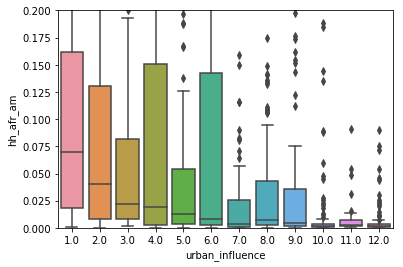

In [311]:
sns.boxplot(y=data['hh_afr_am'], x=data['urban_influence'])
plt.ylim(0, .2)

(0, 0.2)

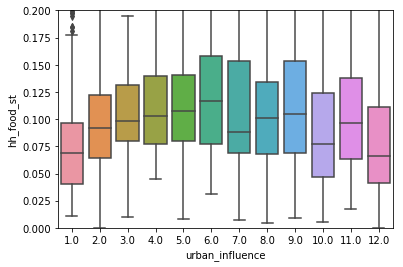

In [312]:
sns.boxplot(y=data['hh_food_st'], x=data['urban_influence'])
plt.ylim(0,.2)

Checking for relationships between **urban_influence** and **hh_afr_am** or **hh_food_st**, there does not appear to be any strong monotonic trend in either.

In [379]:
features2 = list(vif['features'])
data2 = data.loc[:, features2]

In [380]:
outliers2 = get_outliers(data2)
len(data2[outliers.any(axis=1)])

1276

In [381]:
strong_outliers2 = get_outliers(data2, 2.0)
len(data2[strong_outliers2.any(axis=1)])

445

The number of strong outliers is significanlty less than with data1, so try removing these.

In [382]:
features2 = features2 + ['urban_influence', 'death_rate']
data2 = data.loc[:, features2]
data2 = data2.drop(data2[strong_outliers2.any(axis=1)].index)

In [383]:
len(data2)

2579

In [385]:
X2 = data2.drop('death_rate', axis=1)
X2 = pd.get_dummies(X2, prefix='urb_inf_', columns=['urban_influence'])
Y2 = data2.loc[:, 'death_rate']

In [387]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=.35, random_state=57)

In [388]:
for name, clf in zip(names, classifiers):
    %time print('{} scores: {}'.format(name, cross_val_score(clf, X2_train, Y2_train, scoring=matthews)))

Logistic regression scores: [ 0.03383645  0.05288029  0.05804626]
CPU times: user 353 ms, sys: 11.7 ms, total: 365 ms
Wall time: 134 ms
Gradient boosting scores: [ 0.03919663  0.03415788  0.07077783]
CPU times: user 6.5 s, sys: 22.5 ms, total: 6.53 s
Wall time: 6.45 s
SGD scores: [ 0.  0.  0.]
CPU times: user 155 ms, sys: 4.28 ms, total: 159 ms
Wall time: 54.9 ms
Random forest scores: [ 0.04019898  0.05495118  0.06200761]
CPU times: user 209 ms, sys: 3.65 ms, total: 213 ms
Wall time: 117 ms


/Users/vince/anaconda/envs/aind/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/vince/anaconda/envs/aind/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/vince/anaconda/envs/aind/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [389]:
%time print('KNN scores:', cross_val_score(knn, scale.fit_transform(X2_train), Y2_train, scoring=matthews))

KNN scores: [ 0.02715912  0.03834832  0.05517892]
CPU times: user 70.6 ms, sys: 2.29 ms, total: 72.9 ms
Wall time: 71.6 ms


The scores are significantly better, though still poor, and the SGD algorithm ran into an error. 